In [8]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt


In [3]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [7]:
from pandas import read_csv

table = read_csv('/Users/davidguzman/Downloads/Quadranti.csv')

Moggio = table.dropna(how="any")
Moggio = Moggio.reset_index()

values = Moggio.iloc[:,3:].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)
reframed

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var1(t-4),var2(t-4),var3(t-4),...,var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
5,0.0,0.066667,0.088608,0.163005,0.286365,0.000000,0.333333,0.0,0.066667,0.063291,...,0.161552,0.333333,0.0,0.033333,0.101266,0.246694,0.358295,0.112816,0.333333,0.0
6,0.0,0.066667,0.063291,0.130139,0.282413,0.035199,0.333333,0.0,0.122222,0.050633,...,0.112816,0.333333,0.0,0.022222,0.025316,0.075776,0.406390,0.000000,0.000000,0.0
7,0.0,0.122222,0.050633,0.074531,0.353183,0.000000,0.333333,0.0,0.066667,0.088608,...,0.000000,0.000000,0.0,0.077778,0.088608,0.034263,0.397825,0.000000,0.000000,0.0
8,0.0,0.066667,0.088608,0.381024,0.350999,0.161552,0.333333,0.0,0.033333,0.101266,...,0.000000,0.000000,0.0,0.044444,0.050633,0.201140,0.408315,0.000000,0.333333,0.0
9,0.0,0.033333,0.101266,0.246694,0.358295,0.112816,0.333333,0.0,0.022222,0.025316,...,0.000000,0.333333,0.0,0.044444,0.088608,0.063516,0.392536,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,0.0,0.022222,0.012658,0.036869,0.451474,0.000903,0.000000,0.0,0.033333,0.025316,...,0.000000,1.000000,0.0,0.022222,0.000000,0.085947,0.273317,0.000000,0.000000,0.0
2028,0.0,0.033333,0.025316,0.180093,0.432863,0.000000,0.000000,0.0,0.011111,0.037975,...,0.000000,0.000000,0.0,0.044444,0.063291,0.114757,0.198201,0.000000,0.000000,0.0
2029,0.0,0.011111,0.037975,0.168651,0.437366,0.000000,0.000000,0.0,0.022222,0.037975,...,0.000000,0.000000,0.0,0.022222,0.063291,0.126405,0.216521,0.124549,0.333333,0.0
2030,0.0,0.022222,0.037975,0.353177,0.341878,0.000000,1.000000,0.0,0.022222,0.000000,...,0.124549,0.333333,0.0,0.022222,0.000000,0.383468,0.293780,0.009928,0.333333,0.0


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 1667-365 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

Observations: 1015
Training Observations: 509
Testing Observations: 506
Epoch 1/1000


2022-02-20 22:57:15.770415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:57:15.906432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:57:15.961024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:57:16.003529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:57:16.075025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:57:16.152399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:57:16.236957: I tensorflow/core/grappler/optimizers/cust

11/11 - 3s - loss: 0.0712 - val_loss: 0.1011
Epoch 2/1000
11/11 - 0s - loss: 0.0653 - val_loss: 0.0952
Epoch 3/1000
11/11 - 0s - loss: 0.0629 - val_loss: 0.0911
Epoch 4/1000
11/11 - 0s - loss: 0.0595 - val_loss: 0.0885
Epoch 5/1000
11/11 - 0s - loss: 0.0546 - val_loss: 0.0845
Epoch 6/1000
11/11 - 0s - loss: 0.0520 - val_loss: 0.0800
Epoch 7/1000
11/11 - 0s - loss: 0.0501 - val_loss: 0.0754
Epoch 8/1000
11/11 - 0s - loss: 0.0501 - val_loss: 0.0729
Epoch 9/1000
11/11 - 0s - loss: 0.0513 - val_loss: 0.0717
Epoch 10/1000
11/11 - 0s - loss: 0.0537 - val_loss: 0.0774
Epoch 11/1000
11/11 - 0s - loss: 0.0609 - val_loss: 0.0992
Epoch 12/1000
11/11 - 0s - loss: 0.0807 - val_loss: 0.0937
Epoch 13/1000
11/11 - 0s - loss: 0.1101 - val_loss: 0.1101
Epoch 14/1000
11/11 - 0s - loss: 0.0801 - val_loss: 0.0974
Epoch 15/1000
11/11 - 0s - loss: 0.0622 - val_loss: 0.0743
Epoch 16/1000
11/11 - 0s - loss: 0.0567 - val_loss: 0.1041
Epoch 17/1000
11/11 - 0s - loss: 0.1061 - val_loss: 0.0750
Epoch 18/1000
11/11

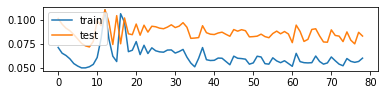

Observations: 1521
Training Observations: 1015
Testing Observations: 506
Epoch 1/1000


2022-02-20 22:57:38.414204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:57:38.546614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:57:38.580892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:57:38.624784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:57:38.693467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:57:38.770831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:57:38.839446: I tensorflow/core/grappler/optimizers/cust

21/21 - 2s - loss: 0.0890 - val_loss: 0.1874
Epoch 2/1000
21/21 - 0s - loss: 0.0814 - val_loss: 0.1752
Epoch 3/1000
21/21 - 0s - loss: 0.0795 - val_loss: 0.1669
Epoch 4/1000
21/21 - 0s - loss: 0.0754 - val_loss: 0.1597
Epoch 5/1000
21/21 - 0s - loss: 0.0700 - val_loss: 0.1337
Epoch 6/1000
21/21 - 0s - loss: 0.0666 - val_loss: 0.1079
Epoch 7/1000
21/21 - 0s - loss: 0.0682 - val_loss: 0.1062
Epoch 8/1000
21/21 - 0s - loss: 0.0646 - val_loss: 0.0912
Epoch 9/1000
21/21 - 0s - loss: 0.0569 - val_loss: 0.0714
Epoch 10/1000
21/21 - 0s - loss: 0.0559 - val_loss: 0.0704
Epoch 11/1000
21/21 - 0s - loss: 0.0527 - val_loss: 0.0786
Epoch 12/1000
21/21 - 0s - loss: 0.0607 - val_loss: 0.0916
Epoch 13/1000
21/21 - 0s - loss: 0.0683 - val_loss: 0.0951
Epoch 14/1000
21/21 - 0s - loss: 0.0905 - val_loss: 0.0884
Epoch 15/1000
21/21 - 0s - loss: 0.1230 - val_loss: 0.1775
Epoch 16/1000
21/21 - 0s - loss: 0.0983 - val_loss: 0.1877
Epoch 17/1000
21/21 - 0s - loss: 0.0926 - val_loss: 0.1765
Epoch 18/1000
21/21

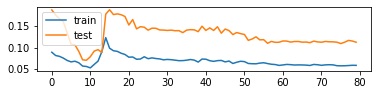

Observations: 2027
Training Observations: 1521
Testing Observations: 506
Epoch 1/1000


2022-02-20 22:58:12.619953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:58:12.752278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:58:12.798801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:58:12.845793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:58:12.915095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:58:12.993941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 22:58:13.076203: I tensorflow/core/grappler/optimizers/cust

31/31 - 3s - loss: 0.1221 - val_loss: 0.1253
Epoch 2/1000
31/31 - 1s - loss: 0.1135 - val_loss: 0.1124
Epoch 3/1000
31/31 - 1s - loss: 0.1015 - val_loss: 0.0894
Epoch 4/1000
31/31 - 1s - loss: 0.0720 - val_loss: 0.1077
Epoch 5/1000
31/31 - 1s - loss: 0.0668 - val_loss: 0.0937
Epoch 6/1000
31/31 - 1s - loss: 0.0650 - val_loss: 0.0910
Epoch 7/1000
31/31 - 1s - loss: 0.0641 - val_loss: 0.0794
Epoch 8/1000
31/31 - 1s - loss: 0.0664 - val_loss: 0.0778
Epoch 9/1000
31/31 - 1s - loss: 0.0741 - val_loss: 0.0863
Epoch 10/1000
31/31 - 1s - loss: 0.0785 - val_loss: 0.0901
Epoch 11/1000
31/31 - 1s - loss: 0.0861 - val_loss: 0.0983
Epoch 12/1000
31/31 - 1s - loss: 0.0955 - val_loss: 0.1349
Epoch 13/1000
31/31 - 1s - loss: 0.1049 - val_loss: 0.1484
Epoch 14/1000
31/31 - 1s - loss: 0.0997 - val_loss: 0.1375
Epoch 15/1000
31/31 - 1s - loss: 0.1039 - val_loss: 0.1456
Epoch 16/1000
31/31 - 1s - loss: 0.1261 - val_loss: 0.1150
Epoch 17/1000
31/31 - 1s - loss: 0.1023 - val_loss: 0.1271
Epoch 18/1000
31/31

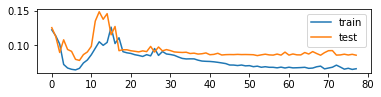

In [31]:
X = reframed.values
n_features = 7
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 0
history = []
for train_index, test_index in splits.split(X):
	train = X[train_index]
	test = X[test_index]
	n_obs = n_days * n_features
	train_X, train_y = train[:, :n_obs], train[:, -1]
	test_X, test_y = test[:, :n_obs], test[:, -1]
	train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
	test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
	print('Observations: %d' % (len(train) + len(test)))
	print('Training Observations: %d' % (len(train)))
	print('Testing Observations: %d' % (len(test)))
	
	model = Sequential()
	model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
	model.add(LSTM(50, return_sequences=True))
	model.add(LSTM(50, return_sequences=False))
	model.add(Dense(1))
	model.compile(loss='mae', optimizer='adam')
	# fit network
	early_stopping = EarlyStopping(patience=70, restore_best_weights = True)
	history.append(model.fit(train_X, train_y, epochs=1000, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping))
	# plot history[index]
	pyplot.subplot(310 + index + 1)
	pyplot.plot(history[index].history['loss'], label='train')
	pyplot.plot(history[index].history['val_loss'], label='test')
	pyplot.legend()
	pyplot.show()

	index += 1
pyplot.show()

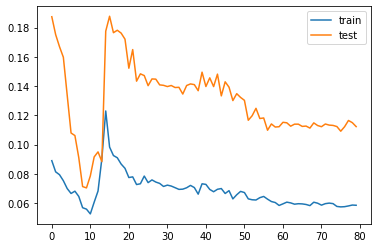

In [33]:
pyplot.plot(history[2].history['loss'], label='train')
pyplot.plot(history[2].history['val_loss'], label='test')
pyplot.legend()
pyplot.show()